# Classification of Normal/Abnormal Heart Sound Recordings
<br>
Last changed: 17 March 2019
<br>

## Random Forest
<br>

In this notebook we use the feature table from the Heart Sound Classification demo from Matlab:
<br> https://nl.mathworks.com/matlabcentral/fileexchange/65286-heart-sound-classifier

The feature table (.mat file) is loaded in Matlab2018b and saved as csv file as follows: <br>

```matlab
  load('FeatureTable.mat');
  writetable(feature_table,'feature_table.csv');
```

The Matab demo feature table is extracted from the Physionet 2016 challenge dataset:

https://www.physionet.org/physiobank/database/challenge/2016/


In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from IPython.display import Image
from IPython.display import display, Markdown, Latex

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# ref.: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def model_evaluation(y_validation, y_prediction, class_labels):
    cnf_matrix = metrics.confusion_matrix(y_validation, y_prediction, labels = class_labels);
    
    # plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_labels, title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_labels, normalize=True, title='Normalized confusion matrix')

    plt.show()
    
    # 
    TN = cnf_matrix[0,0]
    print('TN =', TN)
    TP = cnf_matrix[1,1]
    print('TP =', TP)
    FP = cnf_matrix[0,1]
    print('FP =', FP)
    FN = cnf_matrix[1,0]
    print('FN =', FN)

    print('')
    print('Validation')
    print('Normal:', y_validation.value_counts()[0])
    print('Abnormal:', y_validation.value_counts()[1])
    print('Total:', y_validation.value_counts()[0]+y_validation.value_counts()[1])
    print('Normal %:', 100*round(y_validation.value_counts()[0]/(y_validation.value_counts()[0]+y_validation.value_counts()[1]),2))
    print('Abnormal %:', 100*round(y_validation.value_counts()[1]/(y_validation.value_counts()[0]+y_validation.value_counts()[1]),2))
    print('')
    print('TP+TN+FP+FN =', TP+TN+FP+FN)

    Accuracy = (TP+TN)/(TP+TN+FP+FN)
    Sensitivity = TP/(TP+FN)
    Precision   = TP/(TP+FP)
    F1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

    print('')
    print("Accuracy (sklearn metrics) %:",100*round(metrics.accuracy_score(y_validation, y_prediction),3))
    print("Accuracy %:", 100*round(Accuracy,3))
    print("Score F1:", round(F1,2))
    print('')
    display(Markdown('Of all patients where we predicted abnormal heart sound, what fraction has abnormal heart sound.'))
    print("Precision:", 100*round(Precision,2),"%")
    display(Markdown('Of all patients that have abnormal heart sound, what fraction did we correctly detect.'))
    print("Recall/Sensitivity:", 100*round(Sensitivity,2),"%")
    print('')
    
    return TP, TN, FP, FN, Accuracy, Sensitivity, Precision, F1

## Import dataset

In [4]:
path = './data/feature_table.csv'
dataset = pd.read_csv(path)

In [5]:
dataset.head()

,meanValue,medianValue,standardDeviation,meanAbsoluteDeviation,quantile25,quantile75,signalIQR,sampleSkewness,sampleKurtosis,signalEntropy,...,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13,class
0,-0.000027,0.000153,0.020330,0.012280,-0.008377,0.008209,0.016586,1.448406,21.147144,-2.765938,...,-2.514937,-3.142967,-1.963752,-0.113152,-0.284882,1.621789,-0.533383,-1.692560,-2.023930,Abnormal
1,-0.000004,0.000061,0.021358,0.012943,-0.007904,0.008148,0.016052,0.598251,16.506547,-2.701691,...,-1.742107,-4.678335,-2.733229,2.393984,0.100006,2.916759,-1.341317,-0.905575,-1.491379,Abnormal
2,0.000016,0.000366,0.021588,0.013572,-0.009216,0.008530,0.017746,1.039007,14.776147,-2.643367,...,-0.553855,-1.351164,-2.250663,1.132156,-0.426723,2.394257,1.594562,-2.093305,-1.369329,Abnormal
3,-0.000079,-0.000153,0.019643,0.012688,-0.009018,0.008606,0.017624,0.788818,13.674144,-2.716049,...,-0.740283,-4.181773,-2.078157,1.825690,0.865000,2.492632,-0.916560,-0.552540,-2.229849,Abnormal
4,0.000004,0.000488,0.023276,0.012722,-0.007202,0.007385,0.014587,1.282866,21.825459,-2.770344,...,-0.820515,-5.892187,-2.024111,1.519565,-0.647076,3.923026,-0.563399,-1.758184,-0.482701,Abnormal


In [6]:
list(dataset.columns.values)

['meanValue',
 'medianValue',
 'standardDeviation',
 'meanAbsoluteDeviation',
 'quantile25',
 'quantile75',
 'signalIQR',
 'sampleSkewness',
 'sampleKurtosis',
 'signalEntropy',
 'spectralEntropy',
 'dominantFrequencyValue',
 'dominantFrequencyMagnitude',
 'dominantFrequencyRatio',
 'MFCC1',
 'MFCC2',
 'MFCC3',
 'MFCC4',
 'MFCC5',
 'MFCC6',
 'MFCC7',
 'MFCC8',
 'MFCC9',
 'MFCC10',
 'MFCC11',
 'MFCC12',
 'MFCC13',
 'class']

In [7]:
features = dataset.columns.values[0:27]
print(features)

['meanValue' 'medianValue' 'standardDeviation' 'meanAbsoluteDeviation'
 'quantile25' 'quantile75' 'signalIQR' 'sampleSkewness' 'sampleKurtosis'
 'signalEntropy' 'spectralEntropy' 'dominantFrequencyValue'
 'dominantFrequencyMagnitude' 'dominantFrequencyRatio' 'MFCC1' 'MFCC2'
 'MFCC3' 'MFCC4' 'MFCC5' 'MFCC6' 'MFCC7' 'MFCC8' 'MFCC9' 'MFCC10' 'MFCC11'
 'MFCC12' 'MFCC13']


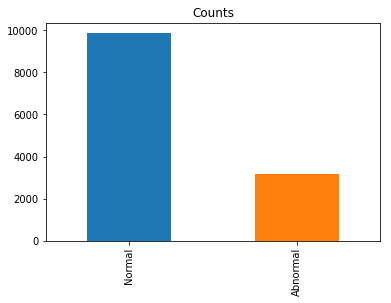

In [8]:
dataset['class'].value_counts().plot(kind='bar', title='Counts');

In [9]:
normal, abnormal = dataset['class'].value_counts()
print('Normal:', normal)
print('Abnormal:', abnormal)
print('Total:', normal+abnormal)

Normal: 9857
Abnormal: 3158
Total: 13015


In [10]:
print('Normal %:', 100*round(normal/(normal+abnormal),3))
print('Abnormal %:', 100*round(abnormal/(normal+abnormal),3))

Normal %: 75.7
Abnormal %: 24.3


In the dataset there are 75.7% normal heart sound samples and 24.3% abnormal heart sound samples. 

In [11]:
class_labels = ["Normal", "Abnormal"]

## Dataset split: Train - Validation - Test

In [13]:
X = dataset[features]
y = dataset['class']
print(len(X))
print(len(y))

13015
13015


In [14]:
val_size = 0.2
test_size = 0.1
new_test_size = np.around(test_size / (val_size + test_size), 2)
print(new_test_size)
new_val_size = 1.0 - new_test_size
print(new_val_size)

0.33
0.6699999999999999


In [15]:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=(val_size + test_size), random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=new_test_size, random_state=1)

In [16]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_val.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 9110 samples.
Validation set has 2616 samples.
Testing set has 1289 samples.


In [17]:
print("Train set:",round(100*len(X_train)/len(X)),'%')
print("Validation set:",round(100*len(X_val)/len(X)),'%')
print("Test set:",round(100*len(X_test)/len(X)),'%')

Train set: 70 %
Validation set: 20 %
Test set: 10 %


In [18]:
print('Train')
print(y_train.value_counts())
print('Normal %:', 100*round(y_train.value_counts()[0]/(y_train.value_counts()[0]+y_train.value_counts()[1]),2))
print('Abnormal %:', 100*round(y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1]),2))

Train
Normal      6939
Abnormal    2171
Name: class, dtype: int64
Normal %: 76.0
Abnormal %: 24.0


In [19]:
print('Validation')
print('Normal:', y_val.value_counts()[0])
print('Abnormal:', y_val.value_counts()[1])
print('Normal %:', 100*round(y_val.value_counts()[0]/(y_val.value_counts()[0]+y_val.value_counts()[1]),2))
print('Abnormal %:', 100*round(y_val.value_counts()[1]/(y_val.value_counts()[0]+y_val.value_counts()[1]),2))

Validation
Normal: 1956
Abnormal: 660
Normal %: 75.0
Abnormal %: 25.0


In [20]:
print('Test')
print(y_test.value_counts())
print('Normal %:', 100*round(y_test.value_counts()[0]/(y_test.value_counts()[0]+y_test.value_counts()[1]),2))
print('Abnormal %:', 100*round(y_test.value_counts()[1]/(y_test.value_counts()[0]+y_test.value_counts()[1]),2))

Test
Normal      962
Abnormal    327
Name: class, dtype: int64
Normal %: 75.0
Abnormal %: 25.0


## Model Training

### Baseline: Logistic regression

As baseline the **Logistic Regression** is taken.

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Confusion matrix, without normalization
[[1832  124]
 [ 251  409]]
Normalized confusion matrix
[[0.93660532 0.06339468]
 [0.38030303 0.61969697]]


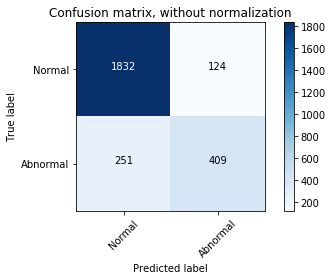

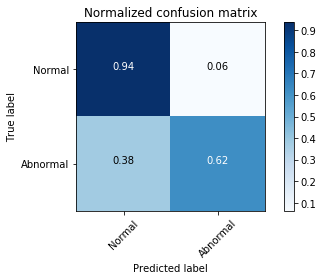

TN = 1832
TP = 409
FP = 124
FN = 251

Validation
Normal: 1956
Abnormal: 660
Total: 2616
Normal %: 75.0
Abnormal %: 25.0

TP+TN+FP+FN = 2616

Accuracy (sklearn metrics) %: 85.7
Accuracy %: 85.7
Score F1: 0.69



Of all patients where we predicted abnormal heart sound, what fraction has abnormal heart sound.

Precision: 77.0 %


Of all patients that have abnormal heart sound, what fraction did we correctly detect.

Recall/Sensitivity: 62.0 %



In [21]:
# instantiate the model (using the default parameters)
clf = LogisticRegression(random_state=0)

# fit the model with data
clf.fit(X_train,y_train)

# predict class labels for samples in the validation set
y_pred_LogisticRegression = clf.predict(X_val)

# parameters classifier
parameters_LogisticRegression = clf.get_params()
print(parameters_LogisticRegression)

# evaluation
Performance_Metrics_LogisticRegression = model_evaluation(y_val, y_pred_LogisticRegression, class_labels)

### Random Forest

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Confusion matrix, without normalization
[[1841  115]
 [ 101  559]]
Normalized confusion matrix
[[0.94120654 0.05879346]
 [0.1530303  0.8469697 ]]


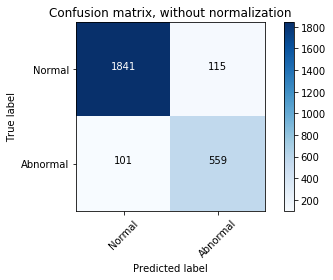

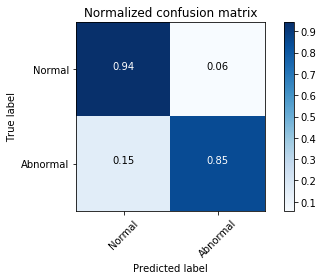

TN = 1841
TP = 559
FP = 115
FN = 101

Validation
Normal: 1956
Abnormal: 660
Total: 2616
Normal %: 75.0
Abnormal %: 25.0

TP+TN+FP+FN = 2616

Accuracy (sklearn metrics) %: 91.7
Accuracy %: 91.7
Score F1: 0.84



Of all patients where we predicted abnormal heart sound, what fraction has abnormal heart sound.

Precision: 83.0 %


Of all patients that have abnormal heart sound, what fraction did we correctly detect.

Recall/Sensitivity: 85.0 %



In [22]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train, y_train)

# predict class labels for samples in the validation set
y_pred_RandomForestClassifier=clf.predict(X_val)

# parameters used by our current forest
parameters_RandomForestClassifier = clf.get_params()
print(parameters_RandomForestClassifier)

# evaluation
Performance_Metrics_RandomForestClassifier = model_evaluation(y_val, y_pred_RandomForestClassifier, class_labels)

### Comparison

In [23]:
# TP, TN, FP, FN, Accuracy, Sensitivity, Precision, F1

In [24]:
Performance_Metrics_LogisticRegression

(409,
 1832,
 124,
 251,
 0.856651376146789,
 0.6196969696969697,
 0.7673545966228893,
 0.685666387259011)

In [25]:
Performance_Metrics_RandomForestClassifier

(559,
 1841,
 115,
 101,
 0.9174311926605505,
 0.8469696969696969,
 0.8293768545994066,
 0.83808095952024)

## Hyperparameter tuning

In [26]:
pass

# [EOF]